In [1]:
import semicon
from semicon.misc import prettify

In [2]:
import scipy
scipy.__version__

'1.2.0.dev0+10233db'

In [3]:
import kwant

import numpy as np
import sympy
sympy.init_printing(print_builtin=False)

# proof of concept

* R rotation from x, y, z to x', y', z'
* n corresponding rotation vector
* primed coordinates: crystalographic axes (Hamiltionian is defined in this coordinates)
* non-primed coordinates: simulation coordinate system

Coordinate transformation:

$
\begin{pmatrix}
x^\prime \\
y^\prime \\
z^\prime \\
\end{pmatrix}
= R
\begin{pmatrix}
x \\
y \\
z \\
\end{pmatrix}
$

with corresponding unitary part:
$
U = \exp(\textrm{i} \, \vec{n} \cdot \vec{S})
$

## test Hamiltonian

In [4]:
tmp = "alpha_{0} * k_{0} * sigma_{0}"
sx, sy, sz = sympy.symbols('sigma_x sigma_y sigma_z')

ham1 = kwant.continuum.sympify(
    " + ".join(tmp.format(s) for s in ['x', 'y', 'z']),
    locals={'sigma_x': sx, 'sigma_y': sy, 'sigma_z': sz}

)

ham2 = kwant.continuum.sympify(" + ".join(tmp.format(s) for s in ['x', 'y', 'z']))

In [5]:
ham1

In [6]:
ham2

⎡     α_z⋅k_z       αₓ⋅kₓ - ⅈ⋅α_y⋅k_y⎤
⎢                                    ⎥
⎣αₓ⋅kₓ + ⅈ⋅α_y⋅k_y      -α_z⋅k_z     ⎦

## Define rotation

In [7]:
import scipy.linalg as la
from scipy.spatial.transform import Rotation


def tmp_rotate(expr, R):
    def rotation_subs(R, v):
        return {cprime: c for (cprime, c) in zip(v, R @ v)}

    subs = rotation_subs(R, sympy.Matrix(kwant.continuum.momentum_operators))
    subs.update(rotation_subs(R, sympy.Matrix([sx, sy, sz])))

    return expr.subs(subs, simultaneous=True).expand()


In [8]:
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

spin_operators = [sigma_x / 2, sigma_y / 2, sigma_z / 2]


R = np.array([[0, -1, 0],
              [+1, 0, 0],
              [0, 0, 1]])

n = Rotation.from_dcm(R).as_rotvec()

ns = np.sum([ni * si for (ni, si) in zip(n, spin_operators)], axis=0)
U = la.expm(1j * ns)

In [9]:
la.det(R)

1.0

## apply test rotation 1

In [10]:
s = tmp_rotate(ham1, R); s

## apply test rotation 2

In [11]:
t = tmp_rotate(ham2, R); t

⎡     α_z⋅k_z        -αₓ⋅k_y - ⅈ⋅α_y⋅kₓ⎤
⎢                                      ⎥
⎣-αₓ⋅k_y + ⅈ⋅α_y⋅kₓ       -α_z⋅k_z     ⎦

In [12]:
t = prettify(U @ t @ U.transpose().conjugate(), decimals=12); t

⎡       1.0⋅α_z⋅k_z         -1.0⋅ⅈ⋅αₓ⋅k_y + 1.0⋅α_y⋅kₓ⎤
⎢                                                     ⎥
⎣1.0⋅ⅈ⋅αₓ⋅k_y + 1.0⋅α_y⋅kₓ         -1.0⋅α_z⋅k_z       ⎦

## test 

In [13]:
prettify(sympy.expand(kwant.continuum.sympify(str(s)) - t), decimals=12)

⎡0  0⎤
⎢    ⎥
⎣0  0⎦

## test with implemented functions

In [14]:
S = kwant.continuum.sympify("[[sigma_x, sigma_y, sigma_z]]") / 2

t = semicon.misc.rotate_symbols(ham2, R)
U = semicon.misc.basis_rotation(R, S)

t = semicon.misc.prettify(U @ t @ U.transpose().conjugate(), decimals=12); t

⎡       1.0⋅α_z⋅k_z         -1.0⋅ⅈ⋅αₓ⋅k_y + 1.0⋅α_y⋅kₓ⎤
⎢                                                     ⎥
⎣1.0⋅ⅈ⋅αₓ⋅k_y + 1.0⋅α_y⋅kₓ         -1.0⋅α_z⋅k_z       ⎦

In [16]:
semicon.misc.prettify(sympy.expand(kwant.continuum.sympify(str(s)) - t), decimals=12)

⎡0  0⎤
⎢    ⎥
⎣0  0⎦

# on kp ham

In [17]:
def rotation110_matrix(xi='0'):
    sin = sympy.sin(xi)
    cos = sympy.cos(xi)
    sqrt2 = sympy.sqrt(2)
    matrix = sympy.Matrix([[+ sin / sqrt2, + cos / sqrt2, 1 / sqrt2],
                           [- sin / sqrt2, - cos / sqrt2, 1 / sqrt2],
                           [cos, - sin, 0]])
    return matrix

R = rotation110_matrix()

In [18]:
import semicon

bands = ('gamma_8v', )
kpham = semicon.models.foreman(bands=bands)
S = semicon.models.spin_operators(bands=bands)
ham = semicon.models.rotate(kpham, R, S)

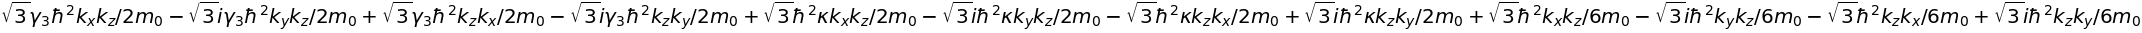

In [19]:
kpham[0, 1]

In [21]:
e = ham[0, 1]

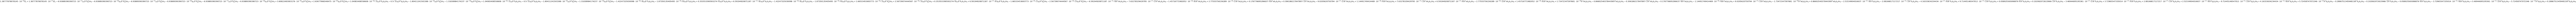

In [22]:
e

In [23]:
prettify(e, 12)

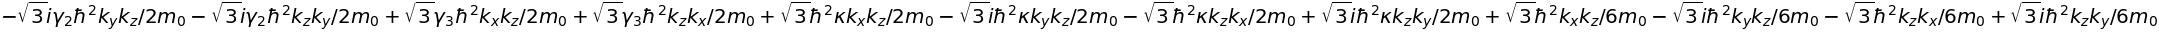

In [24]:
prettify(e, 12, True)